### Imports & Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# GPU Stability Fix
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))


Device: cuda
GPU: NVIDIA GeForce RTX 5050 Laptop GPU


In [2]:
DATASET_PATH = "..\Dataset\pamap2+physical+activity+monitoring\PAMAP2_Dataset\Protocol"    

### PAMAP2 Physical Activity Monitoring
Dataset, available from the UC Irvine Machine Learning Repository.
Source Link:
https://archive.ics.uci.edu/ml/datasets/PAMAP2+Physical+Activity+Monitoring

The dataset was collected using real wearable IoT devices worn by nine participants
performing daily life activities such as walking, running, sitting, cycling, and household
tasks. Each participant wore three wireless inertial measurement units (IMUs) placed
on the wrist, chest, and ankle. These sensors recorded tri-axial acceleration, gyroscope,
magnetometer, and heart rate data in real time. The data was logged at a sampling rate
of 100 Hz, making it a true time-series IoT dataset collected from physical devices in
real environments.

Number of Observations
The dataset contains approximately 3.8 million individual sensor readings across all
participants and activities, making it large enough for deep learning and time-series
prediction tasks.


### Variables in the Dataset
Key variables included in the dataset are:
Timestamp (time series index)

• Accelerometer readings (x, y, z axes)

• Gyroscope readings (x, y, z axes)

• Magnetometer readings (x, y, z axes)

• Heart rate measurements

• Activity label (e.g., walking, sitting, running, etc.)

In [ ]:
cols = [
    "timestamp","activity","heart_rate",
    "acc_x","acc_y","acc_z",  #Accelerometer Sensors 
     # measure movement acceleration in 3D space
    "gyro_x","gyro_y","gyro_z", #Gyroscope Sensors
     # Measure rotation or angular velocity
    "mag_x","mag_y","mag_z" #Magnetometer Sensors
     # Measure orientation relative to Earth’s magnetic field.
]

### Load PAMAP2 Dataset

In [4]:
def load_data(path):

    files = [f for f in os.listdir(path) if f.endswith(".dat")]
    df_list = []

    for file in files:
        temp = pd.read_csv(os.path.join(path,file),
                           sep=' ',
                           header=None)

        temp = temp.iloc[:,:len(cols)]
        temp.columns = cols
        df_list.append(temp)

    return pd.concat(df_list)

df = load_data(DATASET_PATH)

print("Dataset Shape:", df.shape)

Dataset Shape: (2872533, 12)


### Data Cleaning & Processing

In [5]:
df.replace(-1, np.nan, inplace=True)
df.fillna(method='ffill', inplace=True)
df.dropna(inplace=True)

df = df[df['activity'] != 0]

C:\Users\Rajkumar\AppData\Local\Temp\ipykernel_7872\155552814.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [6]:
label_encoder = LabelEncoder()
df['activity'] = label_encoder.fit_transform(df['activity'])

print("Encoded Labels:", df['activity'].unique())

Encoded Labels: [ 0  1  2 10  9  7  8  3  6  5  4 11]


### Exploratory Data Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1942872 entries, 2928 to 7963
Data columns (total 12 columns):
 #   Column      Dtype  
---  ------      -----  
 0   timestamp   float64
 1   activity    int64  
 2   heart_rate  float64
 3   acc_x       float64
 4   acc_y       float64
 5   acc_z       float64
 6   gyro_x      float64
 7   gyro_y      float64
 8   gyro_z      float64
 9   mag_x       float64
 10  mag_y       float64
 11  mag_z       float64
dtypes: float64(11), int64(1)
memory usage: 192.7 MB


In [8]:
df.describe()

,timestamp,activity,heart_rate,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,mag_x,mag_y,mag_z
count,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06,1.942872e+06
mean,1.705202e+03,5.040925e+00,1.074838e+02,3.275126e+01,-4.952946e+00,3.584301e+00,3.602480e+00,-4.886450e+00,3.573040e+00,3.787160e+00,1.867902e-03,3.980977e-02
std,1.093463e+03,3.417153e+00,2.699031e+01,1.794162e+00,6.240453e+00,6.893367e+00,3.956748e+00,6.246913e+00,6.591116e+00,3.942736e+00,1.333056e+00,9.562913e-01
min,3.120000e+01,0.000000e+00,5.700000e+01,2.487500e+01,-1.453670e+02,-1.043010e+02,-1.014520e+02,-6.121470e+01,-6.184170e+01,-6.193470e+01,-2.813540e+01,-1.784950e+01
25%,7.445400e+02,2.000000e+00,8.600000e+01,3.168750e+01,-8.969490e+00,1.057740e+00,1.161628e+00,-8.866020e+00,1.056820e+00,1.363740e+00,-3.782830e-01,-2.239635e-01
50%,1.480330e+03,5.000000e+00,1.040000e+02,3.312500e+01,-5.449750e+00,3.526450e+00,3.431550e+00,-5.377910e+00,3.567485e+00,3.662835e+00,-5.977995e-03,5.945290e-03
75%,2.663610e+03,8.000000e+00,1.240000e+02,3.406250e+01,-9.576388e-01,6.452813e+00,6.531585e+00,-9.061438e-01,6.458552e+00,6.776040e+00,3.364390e-01,2.676743e-01
max,4.245680e+03,1.100000e+01,2.020000e+02,3.550000e+01,6.285960e+01,1.556990e+02,1.577600e+02,5.282140e+01,6.225980e+01,6.192340e+01,2.641580e+01,2.307790e+01


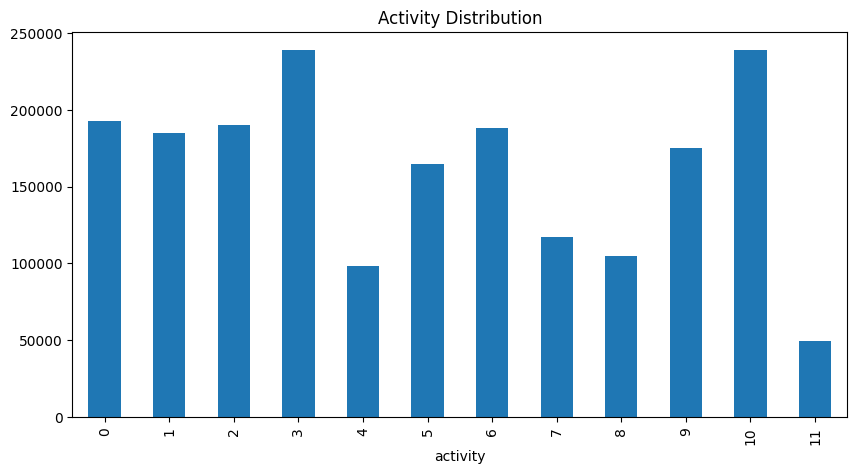

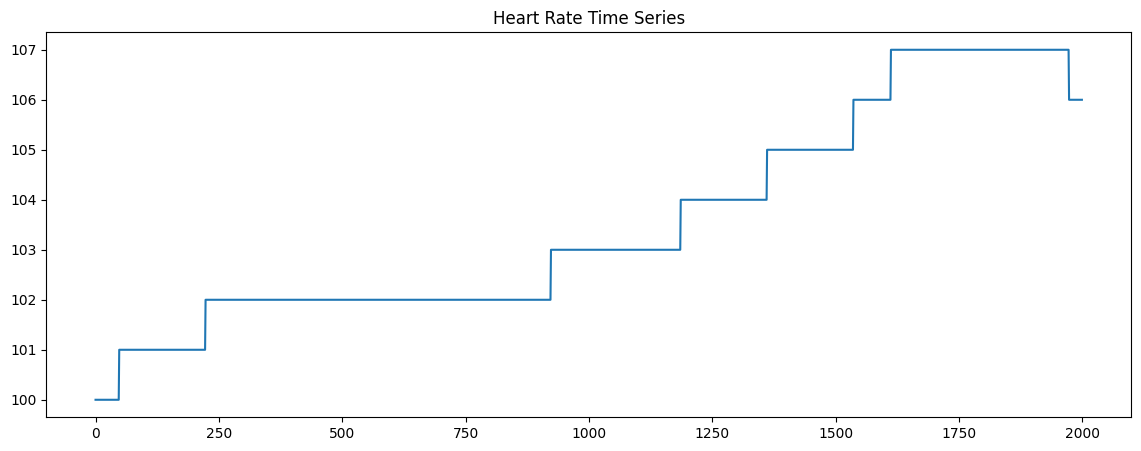

In [9]:
plt.figure(figsize=(10,5))
df['activity'].value_counts().sort_index().plot(kind='bar')
plt.title("Activity Distribution")
plt.show()

plt.figure(figsize=(14,5))
plt.plot(df['heart_rate'].values[:2000])
plt.title("Heart Rate Time Series")
plt.show()

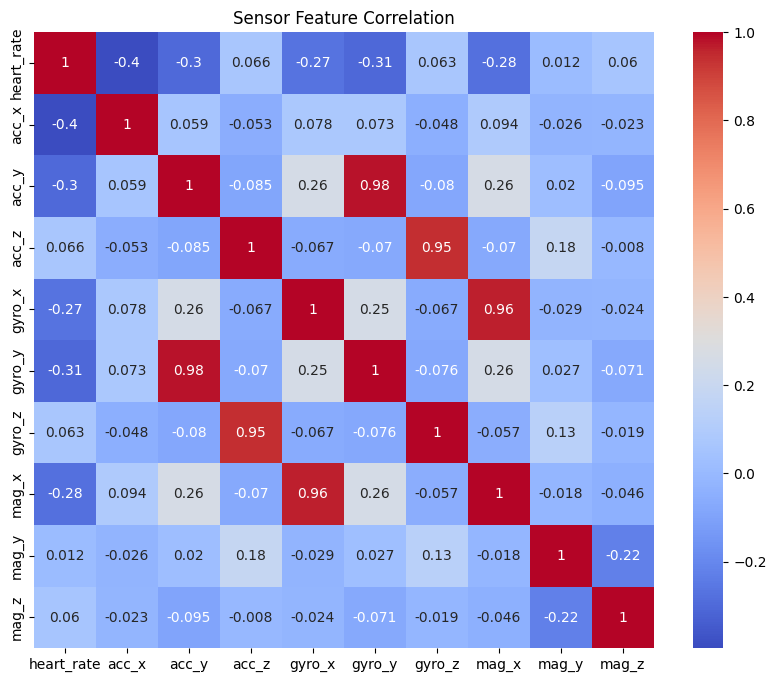

In [10]:
sensor_cols = [
    "heart_rate",
    "acc_x","acc_y","acc_z",
    "gyro_x","gyro_y","gyro_z",
    "mag_x","mag_y","mag_z"
]

plt.figure(figsize=(10,8))
sns.heatmap(df[sensor_cols].corr(), annot=True, cmap="coolwarm")
plt.title("Sensor Feature Correlation")
plt.show()


In [11]:
features = df.drop(['activity'], axis=1)
labels = df['activity'].astype(int)

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(features)

### Create Sequences (Time Series Windows)

In [12]:
def create_sequences(X, y, window=50):

    Xs, ys = [], []

    for i in range(len(X)-window):
        Xs.append(X[i:i+window])
        ys.append(y.iloc[i+window])

    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(pd.DataFrame(X_scaled), labels)

print(X_seq.shape, y_seq.shape)


(1942822, 50, 11) (1942822,)


### Train/Test Data Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq,
    test_size=0.2,
    random_state=42
)
print("Train Shape:", X_train.shape, y_train.shape)
print("Test Shape:", X_test.shape, y_test.shape)


Train Shape: (1554257, 50, 11) (1554257,)
Test Shape: (388565, 50, 11) (388565,)


### Dataset Loader

In [14]:
class PAMAPDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = PAMAPDataset(X_train, y_train)
test_ds = PAMAPDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=128)


## DEEP LEARNING MODEL 1

### Activity Classification LSTM

This is a feed-forward Artificial Neural Network (ANN) used to classify physical movement based on multi-sensor input.
-	Type: Deep Learning Classifier (Multilayer Perceptron).
-	Target Variable: activity (Categorical).
-	This predicts which specific activity a user is performing (e.g., walking, sitting, running, etc.) based on the sensor readings at a given moment.
####	Architecture Details:
-	Input Layer: Accepts a 10-dimensional feature vector consisting of 3-axis accelerometer, 3-axis gyroscope, 3-axis magnetometer, and heart rate readings.
-	Hidden Layers: Three linear (dense) layers with 64, 128, and 64 neurons respectively.
-	Activation & Regularization: Uses ReLU activation functions and Dropout layers (p=0.2) to prevent overfitting during training.
-	Output Layer: A linear layer with 12 nodes (representing the 12 activity classes) used with CrossEntropyLoss.

In [ ]:
num_classes = len(np.unique(y_train))

class ActivityLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()

        self.lstm = nn.LSTM(input_size,
                            hidden_size,
                            batch_first=True)

        self.fc1 = nn.Linear(hidden_size,64)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(64,num_classes)

    def forward(self,x):

        out,_ = self.lstm(x)
        out = out[:,-1,:]

        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        
        return out

model = ActivityLSTM(
    input_size=X_train.shape[2],
    hidden_size=64,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


### Activity Classification LSTM

In [16]:
train_losses = []

epochs = 10

for epoch in range(epochs):

    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()

        outputs = model(X_batch)
        loss = criterion(outputs.float(), y_batch)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    train_losses.append(total_loss)

    print(f"Epoch {epoch+1}, Loss {total_loss:.4f}")


Epoch 1, Loss 4645.0835
Epoch 2, Loss 1143.9481
Epoch 3, Loss 784.5786
Epoch 4, Loss 557.1372
Epoch 5, Loss 440.2459
Epoch 6, Loss 391.7806
Epoch 7, Loss 321.0735
Epoch 8, Loss 284.5736
Epoch 9, Loss 263.0435
Epoch 10, Loss 236.6841


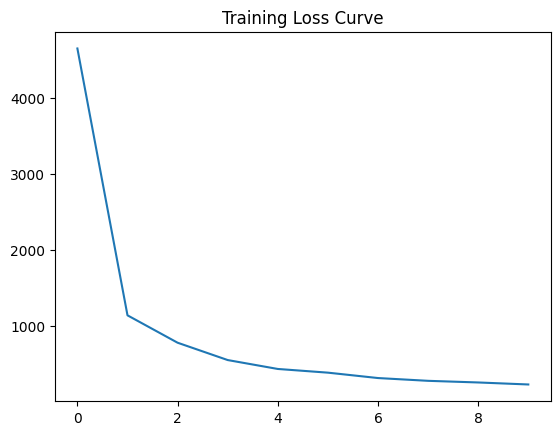

In [17]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.show()

### Activity Classification LSTM

In [18]:
model.eval()

all_preds = []
all_true = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:

        X_batch = X_batch.to(device)
        outputs = model(X_batch)

        preds = torch.argmax(outputs, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_true.extend(y_batch.numpy())

acc = accuracy_score(all_true, all_preds)
print("Activity Accuracy:", acc)


Activity Accuracy: 0.9938260007978074


In [19]:
# Create folder if not exists
os.makedirs("saved_models", exist_ok=True)

# Save model weights
torch.save(model.state_dict(), "saved_models/activity_lstm.pth")

print("✅ Activity model saved")


✅ Activity model saved


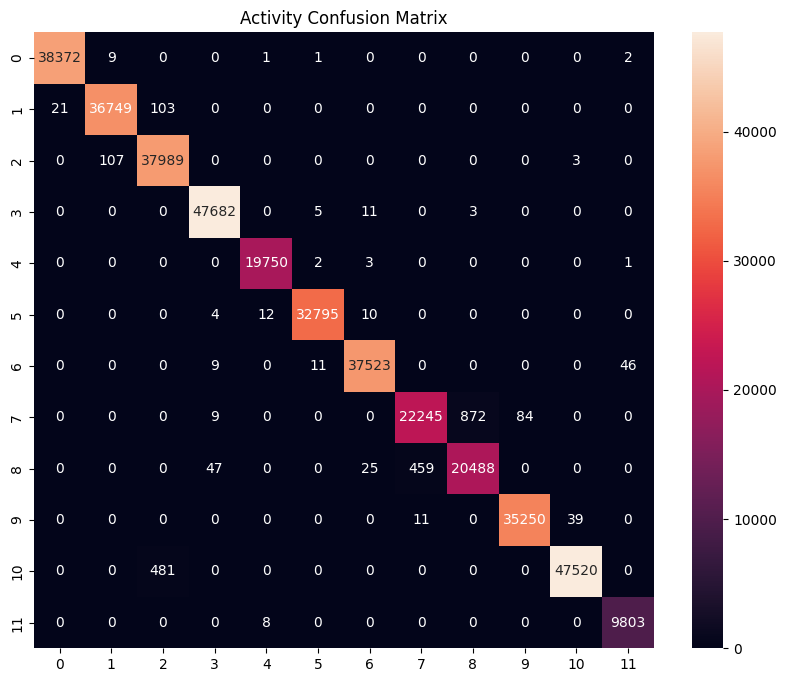

In [20]:
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d')
plt.title("Activity Confusion Matrix")
plt.show()


### Activity Model Inference Test

In [22]:
# Take ONE test sample as input
sample_input = torch.tensor(X_test[0], dtype=torch.float32).unsqueeze(0).to(device)

model.eval()

with torch.no_grad():
    output = model(sample_input)
    predicted_class = torch.argmax(output, dim=1).item()


# Convert back to label name (if using LabelEncoder)
print("Predicted Activity Label:",
      label_encoder.inverse_transform([predicted_class])[0])


Predicted Activity Label: 7


## DEEP LEARNING MODEL 2

### Time Series Prediction (Heart Rate Forecast)

This is a recurrent neural network designed to forecast future physiological data based on past temporal sequences.
-	Type: Deep Learning Time-Series Predictor (LSTM).
-	Target Variable: heart_rate (Continuous).
-	This predicts the future heart rate value based on the previous sequence of sensor data, allowing the system to anticipate cardiovascular trends.
####	Architecture Details:
-	Recurrent Layer: A Long Short-Term Memory (LSTM) layer with a hidden dimension of 50.
-	Sequence Processing: It utilizes a "sliding window" of the past 10 timestamps to project the next value in the series.
-	Output Layer: A fully connected linear layer that maps the LSTM's hidden state to a single continuous numerical value (regression).
-	Loss Function: Trained using Mean Squared Error (MSE), which is standard for time-series regression tasks.

In [23]:
hr = df['heart_rate'].values.reshape(-1,1)

def create_hr_sequences(data, window=30):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X_hr, y_hr = create_hr_sequences(hr)

X_hr_train, X_hr_test, y_hr_train, y_hr_test = train_test_split(
    X_hr, y_hr, test_size=0.2, random_state=42
)



In [24]:
# Heart Rate LSTM Model

class HRLSTM(nn.Module):

    def __init__(self):
        super().__init__()

        self.lstm = nn.LSTM(1,50,batch_first=True)
        self.fc = nn.Linear(50,1)

    def forward(self,x):
        out,_ = self.lstm(x)
        out = out[:,-1,:]
        out = self.fc(out)
        return out

# Create model
hr_model = HRLSTM().to(device)

# Loss + Optimizer
criterion_hr = nn.MSELoss()
optimizer_hr = torch.optim.Adam(hr_model.parameters(), lr=0.001)

print("✅ HR model initialized")


✅ HR model initialized


In [25]:
class HRDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

hr_train_ds = HRDataset(X_hr_train, y_hr_train)
hr_train_loader = DataLoader(hr_train_ds, batch_size=128, shuffle=True)


### Train HR Model

In [26]:
torch.cuda.empty_cache()

epochs = 5

for epoch in range(epochs):

    hr_model.train()
    total_loss = 0

    for X_batch, y_batch in hr_train_loader:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer_hr.zero_grad()

        output = hr_model(X_batch)

        loss = criterion_hr(output, y_batch)

        loss.backward()
        optimizer_hr.step()

        total_loss += loss.item()

    print(f"HR Epoch {epoch+1}, Loss {total_loss:.4f}")


HR Epoch 1, Loss 12054364.0291
HR Epoch 2, Loss 1870.3904
HR Epoch 3, Loss 705.2903
HR Epoch 4, Loss 645.5010
HR Epoch 5, Loss 637.2135


In [27]:
# Create HR test loader
hr_test_loader = DataLoader(
    HRDataset(X_hr_test, y_hr_test),
    batch_size=128,
    shuffle=False
)
hr_model.eval()
all_hr_preds = []
torch.cuda.empty_cache()
with torch.no_grad():
    for X_batch, _ in hr_test_loader:
        X_batch = X_batch.to(device)
        batch_preds = hr_model(X_batch).cpu().numpy()
        all_hr_preds.extend(batch_preds)
preds = np.array(all_hr_preds)


### HR Forecast Visualization

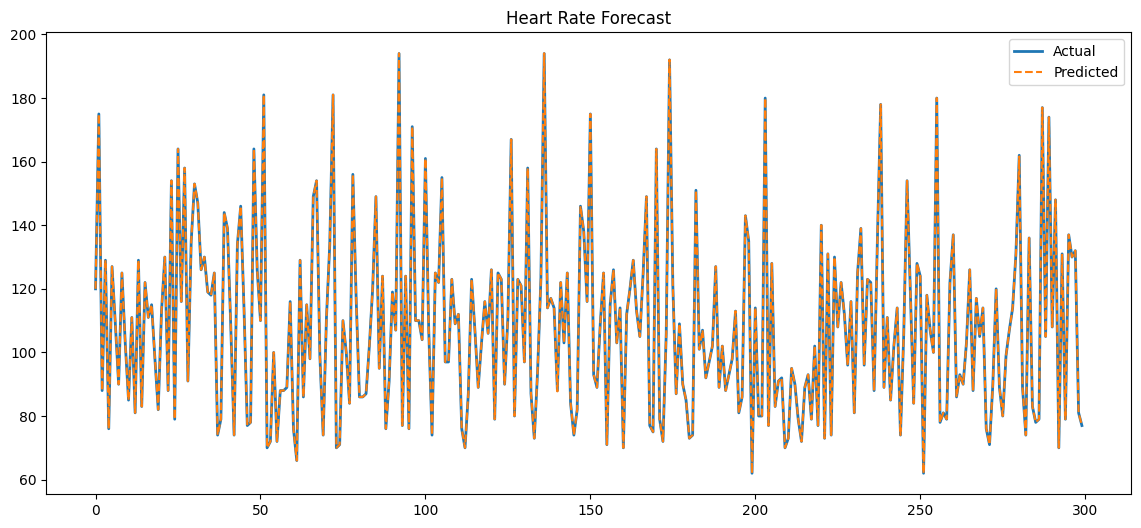

In [28]:
plt.figure(figsize=(14,6))
plt.plot(y_hr_test[:300], linewidth=2)
plt.plot(preds[:300], linestyle='--')
plt.title("Heart Rate Forecast")
plt.legend(["Actual","Predicted"])
plt.show()


In [29]:
torch.save(hr_model.state_dict(), "saved_models/hr_lstm.pth")

print("✅ Heart rate model saved")


✅ Heart rate model saved


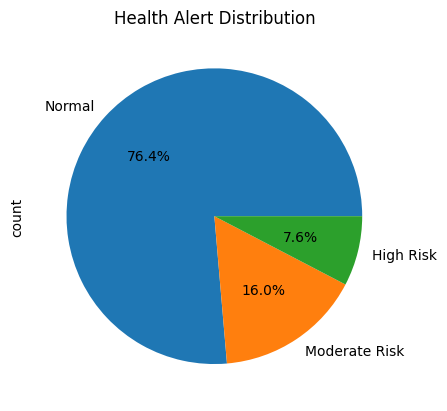

In [30]:
def detect_anomaly(hr):
    if hr>150:return "High Risk"
    elif hr<80:return "Moderate Risk"
    return "Normal"

df['hr_alert']=df['heart_rate'].apply(detect_anomaly)

df['hr_alert'].value_counts().plot(kind='pie',autopct='%1.1f%%')
plt.title("Health Alert Distribution")
plt.show()


In [32]:
# Take ONE sequence input
hr_input = torch.tensor(X_hr_test[0], dtype=torch.float32).unsqueeze(0).to(device)

hr_model.eval()

with torch.no_grad():
    hr_prediction = hr_model(hr_input).item()

print("Predicted Future Heart Rate:", hr_prediction)


Predicted Future Heart Rate: 120.01443481445312


In [42]:
import pandas as pd

# --- Activity results ---
activity_df = pd.DataFrame({
    "Actual_Activity": all_true,
    "Predicted_Activity": all_preds
})

# --- HR results ---
hr_df = pd.DataFrame({
    "Actual_HR": y_hr_test.flatten(),
    "Predicted_HR": preds.flatten()
})

# --- Alerts + timestamp (only required fields) ---
alerts_df = df[['timestamp','heart_rate','hr_alert']].reset_index(drop=True)

# Make all same length
min_len = min(len(activity_df), len(hr_df), len(alerts_df))

clean_dashboard_df = pd.concat([
    alerts_df.iloc[:min_len],
    activity_df.iloc[:min_len],
    hr_df.iloc[:min_len]
], axis=1)

# Rename heart_rate column to match HR naming
clean_dashboard_df.rename(columns={"heart_rate":"Sensor_HR"}, inplace=True)

# Save clean CSV
clean_dashboard_df.to_csv("smart_wearable_clean_dashboard.csv", index=False)

print("✅ Clean Tableau CSV created")


✅ Clean Tableau CSV created
